In [1]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
!pip install -q mediapipe==0.10.0

In [27]:
!pip install ffmpegio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 3.3 MB/s eta 0:00:004.8 MB/s eta 0:00:01


In [1]:
import mediapipe as mp
from mediapipe.tasks.python import vision
from mediapipe.tasks import python
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ffmpegio

In [2]:
def apply2Video(callFunction, videoPath="2023-09-12 18-34-56.mp4", cvt=None,**kwargs):
    '''
    Function that applies to every frame  of the video the 'callFunction'.
    ---------------------------------------------------------------------
    callFunction = function that 
    videoPath = path to the video
    cvt = colorsecheme  -Optional  (cv2.COLOR_RGB2GRAY,cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HSV, ....)
    
    ---------------------------------------------------------------------
    Returns a list with the callback output
    '''
    cap = cv2.VideoCapture(videoPath)
    output = []
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break
        if not(cvt is None):
            image = cv2.cvtColor(image,cvt)
        output.append(callFunction(image,**kwargs))
    cap.release()
    return output

# 1. Capturando video

In [3]:
def getFrames(frame):
    return frame

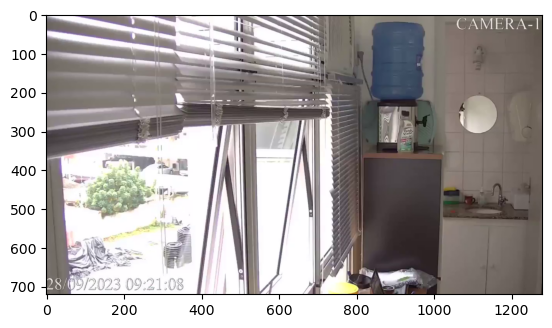

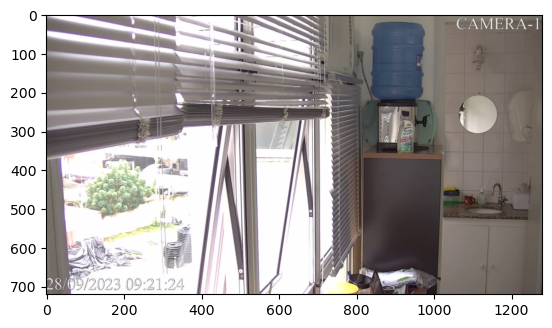

In [15]:
imgs = apply2Video(getFrames,"https://mediaserver.eadmeeting.com:5443/LiveApp/streams/071b3922-5c72-11ee-80cf-7085c223e95e_720p.mp4",cv2.COLOR_BGR2RGB)
imgs = np.array(imgs)
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[-1])
plt.show()

# 2. Exemplo de métrica simples

In [6]:
def getAverage(frame):
    return np.average(frame)

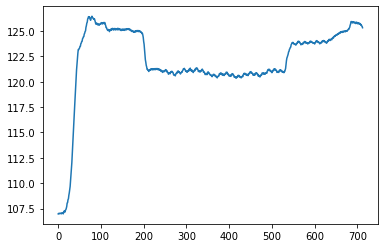

In [7]:
average = apply2Video(getAverage,"2023-09-12 18-34-56.mp4",cv2.COLOR_BGR2GRAY)
average = np.array(average)
plt.figure()
plt.plot(average)
plt.show()

# 3. MediaPipe - Bones

In [4]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks])
        solutions.drawing_utils.draw_landmarks(
              annotated_image,
              pose_landmarks_proto,
              solutions.pose.POSE_CONNECTIONS,
              solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image


# contruindo detector (global)
def getDetector():
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)
    return detector

def getBonesImages(frame,detector):
    # criando imagem do tipo MediaPipe e aplicando o detector
    mpFrame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    results = detector.detect(mpFrame)
    return draw_landmarks_on_image(frame,results)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


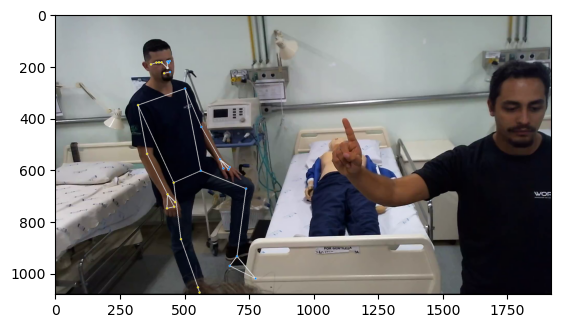

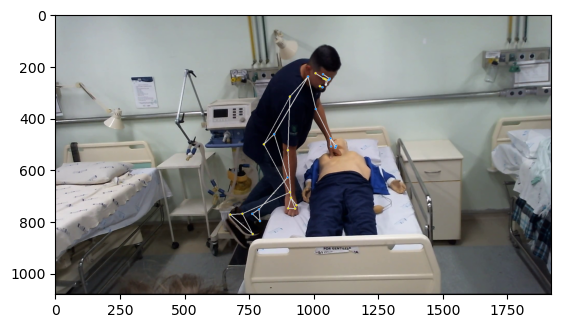

In [5]:
imgs = apply2Video(getBonesImages,"2023-09-12 18-34-56.mp4",cv2.COLOR_BGR2RGB,detector=getDetector())
imgs = np.array(imgs)
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[-1])
plt.show()

In [29]:
ffmpegio.video.write('bones.mp4', 20.0, imgs)

Input #0, rawvideo, from 'pipe:':
  Duration: N/A, start: 0.000000, bitrate: 995328 kb/s
    Stream #0:0: Video: rawvideo (RGB[24] / 0x18424752), rgb24, 1920x1080, 995328 kb/s, 20 tbr, 20 tbn, 20 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> h264 (libx264))
[libx264 @ 0x562cff53c640] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x562cff53c640] profile High 4:4:4 Predictive, level 4.0, 4:4:4, 8-bit
[libx264 @ 0x562cff53c640] 264 - core 161 r3030M 8bd6d28 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=18 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=25

# 4. MediaPipe - Métrica braços

In [7]:
def euclid(arr):
    return np.sqrt(np.sum(arr**2))

def getCoord(landmark):
    return np.array([landmark.x,landmark.y,landmark.z])

def b2p(detection_result):
    metric = []
    points = detection_result.pose_landmarks[0]
    set1 = [points[16].visibility,points[14].visibility,points[12].visibility,points[24].visibility]
    set2 = [points[15].visibility,points[13].visibility,points[11].visibility,points[23].visibility]
    if np.average(set1)>np.average(set2):
        hand,elbow,shoulder,hips = getCoord(points[16]),getCoord(points[14]),getCoord(points[12]),getCoord(points[24])
    else:
        hand,elbow,shoulder,hips = getCoord(points[15]),getCoord(points[13]),getCoord(points[11]),getCoord(points[23])
    v1 = hips-shoulder
    v2 = elbow-shoulder
    metric.append(np.dot(v1,v2)/(euclid(v1)*euclid(v2)))
    
    v1 = hand-elbow
    v2 = shoulder-elbow
    metric.append(np.dot(v1,v2)/(euclid(v1)*euclid(v2)))
    return np.average(metric)

# contruindo detector (global)
def getDetector():
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)
    return detector

def getBonesImages(frame,detector):
    mpFrame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    results = detector.detect(mpFrame)
    return b2p(results)

In [27]:
seq = apply2Video(getBonesImages,"2023-09-12 18-34-56.mp4",cv2.COLOR_BGR2RGB,detector=getDetector())

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
def plot(t):
    gs = GridSpec(2,1,height_ratios=[4,1])
    plt.figure(figsize=(10,10))
    plt.subplot(gs[0,0])
    plt.imshow(imgs[t])
    plt.subplot(gs[1,0])
    plt.plot(seq)
    plt.xlim(0,len(seq))
    plt.ylabel("B2P",fontsize=20)
    plt.xlabel("Frame",fontsize=20)
    plt.axvline(t,color='r',ls='--')
    plt.tight_layout()
    #ncols, nrows = fig.canvas.get_width_height()
    #data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(ncols, nrows,3).copy()
    plt.savefig(f"snaps/s{t}.png")
    plt.close()
    
sysSnap = []
for i in tqdm(range(len(seq))):
    plot(i)

In [ ]:
!ffmpeg -y -framerate 20 -i snaps/s%01d.png -c:v copy b2p.mkv

# 5. Media Pipe -B1P


In [9]:
def euclid(arr):
    return np.sqrt(np.sum(arr**2))

def getCoord(landmark):
    return np.array([landmark.x,landmark.y,landmark.z])

def b1p(detection_result):
    metric = []
    points = detection_result.pose_landmarks[0]
    set1 = [points[12].visibility,points[24].visibility,points[26].visibility]
    set2 = [points[11].visibility,points[23].visibility,points[25].visibility]
    if np.average(set1)>np.average(set2):
        shoulder,hips,knee = getCoord(points[12]),getCoord(points[24]),getCoord(points[26])
    else:
        shoulder,hips,knee = getCoord(points[11]),getCoord(points[23]),getCoord(points[25])
    v1 = shoulder-hips
    v2 = knee-hips
    metric.append(np.dot(v1,v2)/(euclid(v1)*euclid(v2)))
    
    return metric

# contruindo detector (global)
def getDetector():
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)
    return detector

def getBonesImages(frame,detector):
    mpFrame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    results = detector.detect(mpFrame)
    return b1p(results)

In [10]:
seq = apply2Video(getBonesImages,"2023-09-12 18-34-56.mp4",cv2.COLOR_BGR2RGB,detector=getDetector())

In [11]:
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
def plot(t):
    gs = GridSpec(2,1,height_ratios=[4,1])
    plt.figure(figsize=(10,10))
    plt.subplot(gs[0,0])
    plt.imshow(imgs[t])
    plt.subplot(gs[1,0])
    plt.plot(seq)
    plt.xlim(0,len(seq))
    plt.ylabel("B1P",fontsize=20)
    plt.xlabel("Frame",fontsize=20)
    plt.axvline(t,color='r',ls='--')
    plt.tight_layout()
    #ncols, nrows = fig.canvas.get_width_height()
    #data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(ncols, nrows,3).copy()
    plt.savefig(f"snaps/s{t}.png")
    plt.close()
    
sysSnap = []
for i in tqdm(range(len(seq))):
    plot(i)

100%|███████████████████████████████████████████████████| 713/713 [04:45<00:00,  2.50it/s]


In [12]:
!ffmpeg -y -framerate 20 -i snaps/s%01d.png -c:v copy b1p.mkv

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
